In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RepeatedKFold

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
train = pd.read_csv('../bigquery-geotab-intersection-congestion/train.csv')
test = pd.read_csv('../bigquery-geotab-intersection-congestion/test.csv')
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta


View test and train shape

In [10]:
print("train dataset :",train.shape)
print("test dataset :", test.shape)

train dataset : (856387, 28)
test dataset : (1921357, 13)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921357 entries, 0 to 1921356
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   RowId            int64  
 1   IntersectionId   int64  
 2   Latitude         float64
 3   Longitude        float64
 4   EntryStreetName  object 
 5   ExitStreetName   object 
 6   EntryHeading     object 
 7   ExitHeading      object 
 8   Hour             int64  
 9   Weekend          int64  
 10  Month            int64  
 11  Path             object 
 12  City             object 
dtypes: float64(2), int64(5), object(6)
memory usage: 190.6+ MB


### Lets see common Cities between our train and test set

In [15]:
print("Cities in Train dataset:", train['City'].unique().tolist())
print("Cities in Test dataset:", test['City'].unique().tolist())

Cities in Train dataset: ['Atlanta', 'Boston', 'Chicago', 'Philadelphia']
Cities in Test dataset: ['Atlanta', 'Boston', 'Chicago', 'Philadelphia']


In [21]:
city = train.groupby('City').size().reset_index()
city

,City,0
0,Atlanta,156484
1,Boston,178617
2,Chicago,131049
3,Philadelphia,390237


In [19]:
city1 = test.groupby('City').size()
city1

City
Atlanta         341852
Boston          409275
Chicago         298129
Philadelphia    872101
dtype: int64

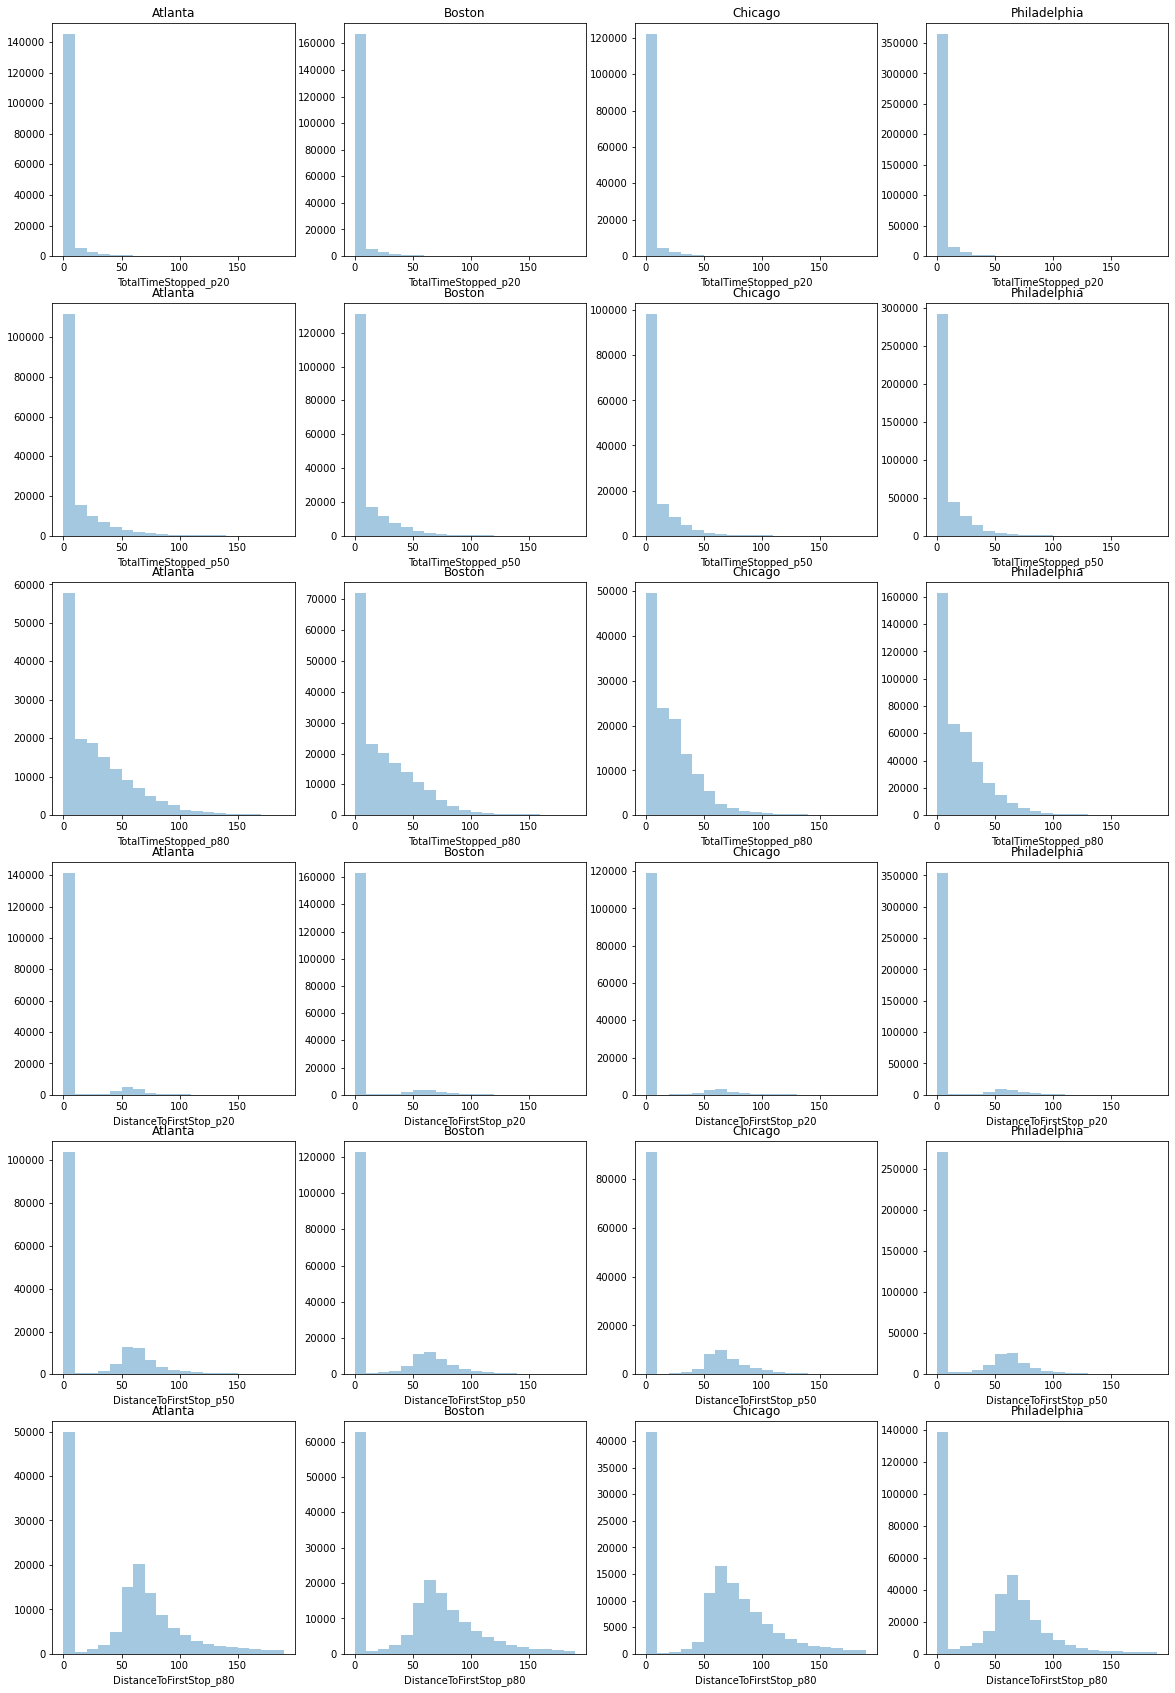

In [25]:
target_vars = ['TotalTimeStopped_p20', 'TotalTimeStopped_p50', 
               'TotalTimeStopped_p80', 'DistanceToFirstStop_p20', 
               'DistanceToFirstStop_p50', 'DistanceToFirstStop_p80']
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20,30))
cities = train.City.unique()
bins = list(range(0, 200, 10))
for i, var in enumerate(target_vars):
    for j, city in enumerate(cities):
        sns.distplot(train[train.City == city][var], bins=bins, kde=False, ax=ax[i, j]).set_title(city)

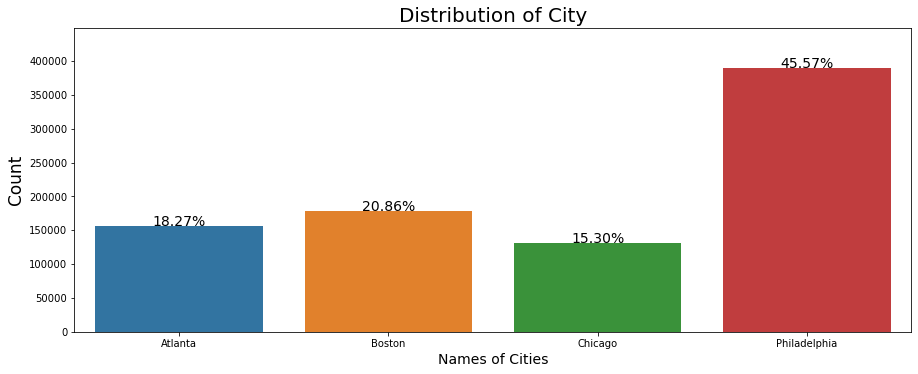

In [29]:
train_len = len(train)
plt.figure(figsize=(15,19))

plt.subplot(311)
val = sns.countplot(x="City", data=train)
val.set_title("Distribution of City", fontsize=20)
val.set_ylabel("Count",fontsize= 17)
val.set_xlabel("Names of Cities", fontsize=14)
sizes=[]
for i in val.patches:
    height = i.get_height()
    sizes.append(height)
    val.text(i.get_x()+i.get_width()/2., height + 3, '{:1.2f}%'.format(height/train_len*100), ha="center", fontsize=14) 
val.set_ylim(0, max(sizes) * 1.15)

plt.show()


#### From the above observation, the city Philadelphia has approximately 46% of total entires which is the highest as compared to Atlanta, Boston and Chicago.

In [31]:
hour_dist = train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()
hour_dist

,City,Hour,RowId
0,Atlanta,0,6340
1,Atlanta,1,5544
2,Atlanta,2,4542
3,Atlanta,3,3791
4,Atlanta,4,2890
...,...,...,...
91,Philadelphia,19,18538
92,Philadelphia,20,18499
93,Philadelphia,21,18834
94,Philadelphia,22,18512


#### Hourly Distribution

(0.0, 23036.8)

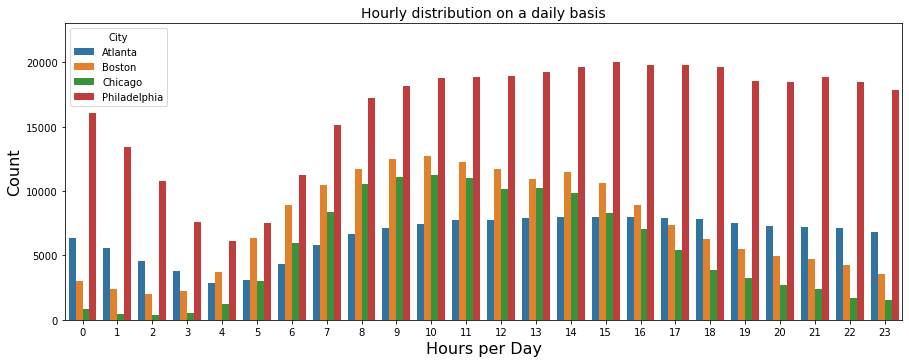

In [33]:
plt.figure(figsize=(15,12))

plt.subplot(211)
val = sns.countplot(x="Hour", data=train, hue='City', dodge=True)
val.set_title("Hourly distribution on a daily basis", fontsize=14)
val.set_ylabel("Count",fontsize= 16)
val.set_xlabel("Hours per Day", fontsize=16)
sizes=[]
for i in val.patches:
    height = i.get_height()
    sizes.append(height)

val.set_ylim(0, max(sizes) * 1.15)

- Observation shows that high variations on hours of entry. 
- Meanwhile Atlanta shows less entires on the daily report shown above. From 9:00am to 18:00 there is an increase with the number of entires but stil less compared to other cities.

(0.0, 70335.15)

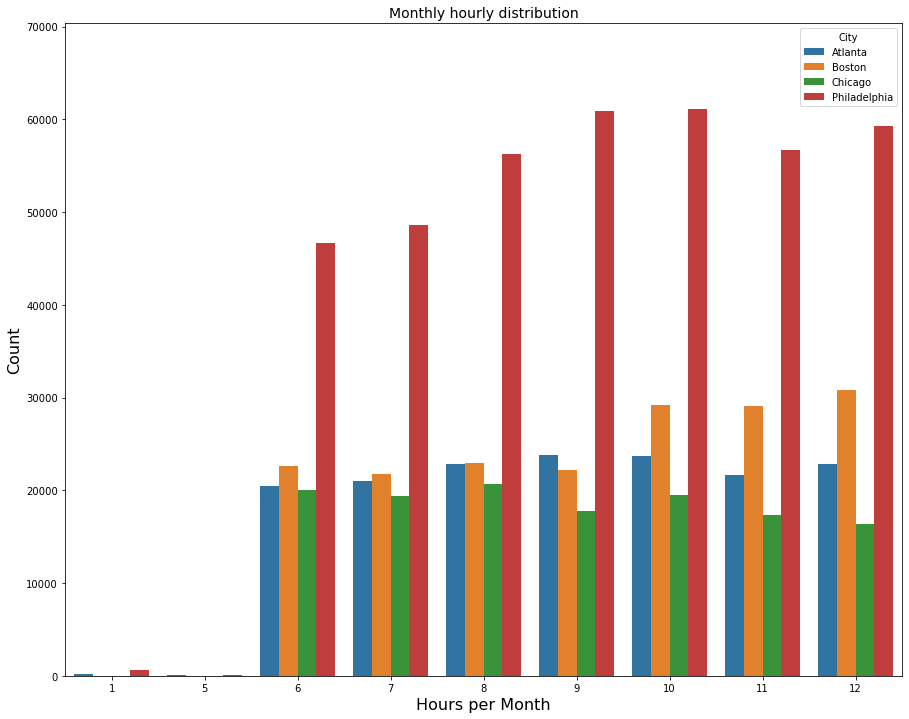

In [36]:
plt.figure(figsize=(15,12))

plt.subplot(211)
val = sns.countplot(x="Month", data=train, hue='City', dodge=True)
val.set_title("Monthly hourly distribution", fontsize=14)
val.set_ylabel("Count",fontsize= 16)
val.set_xlabel("Hours per Month", fontsize=16)
sizes=[]
for i in val.patches:
    height = i.get_height()
    sizes.append(height)

val.set_ylim(0, max(sizes) * 1.15)

- Seen from the above distribution dataset has most enties from the sixth month(June) up to December.